In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

C:\Users\nicol\AppData\Local\Temp\ipykernel_30868\1233369388.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
# loading the dataset
SP500_stocks = pd.read_csv('SP500_stock_prices.csv')
# assign each different Sector string its own number
SP500_stocks['Sector'] = SP500_stocks['Sector'].map({'Consumer Discretionary': 0, 'Consumer Staples': 1, 'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5, 'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Communication Services': 9, 'Utilities': 10})
SP500_stocks.head()

,Date,Ticker,Open,Low,High,Close,Volume,Sector
0,2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,5
1,2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,5
2,2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,5
3,2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,5
4,2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,5


In [5]:
# getting companyList
stockList = SP500_stocks['Ticker'].unique()[0:10]
# getting the data for each company
df_ = {}

for stock in stockList:
    df_[stock] = SP500_stocks[SP500_stocks['Ticker'] == stock]
    # remove the Ticker column
    df_[stock] = df_[stock].drop(['Ticker'], axis=1)
    # set the date as the index
    df_[stock] = df_[stock].set_index('Date')

# remove dates past february 2020
#for stock in stockList:
    #df_[stock] = df_[stock].loc[:'2020-04-02']

df_

{'MMM':                   Open         Low        High       Close   Volume  Sector
 Date                                                                       
 2016-01-04  148.050003  145.399994  148.320007  146.820007  3277200       5
 2016-01-05  146.820007  145.610001  147.500000  147.460007  2688100       5
 2016-01-06  145.589996  143.419998  145.759995  144.490005  2997100       5
 2016-01-07  142.520004  140.630005  143.130005  140.970001  3553500       5
 2016-01-08  141.360001  140.220001  142.500000  140.490005  2664000       5
 ...                ...         ...         ...         ...      ...     ...
 2020-03-26  131.789993  130.610001  136.380005  136.179993  6717000       5
 2020-03-27  132.830002  130.910004  137.070007  133.240005  4262300       5
 2020-03-30  132.250000  131.059998  138.009995  137.740005  3869500       5
 2020-03-31  135.690002  135.679993  139.440002  136.509995  3613700       5
 2020-04-01  132.000000  131.009995  135.839996  133.139999  3777600 

In [6]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for stock in stockList:
    df_new[stock] = {}
    df_new[stock]["Train"], df_new[stock]["Test"] = split(df_[stock], "2019-06-01", ["Close"])

In [7]:
df_new

{'MMM': {'Train':                  Close
  Date                  
  2016-01-04  146.820007
  2016-01-05  147.460007
  2016-01-06  144.490005
  2016-01-07  140.970001
  2016-01-08  140.490005
  ...                ...
  2019-05-24  166.089996
  2019-05-28  163.350006
  2019-05-29  161.399994
  2019-05-30  160.580002
  2019-05-31  159.750000
  
  [858 rows x 1 columns],
  'Test':                  Close
  Date                  
  2019-06-03  160.039993
  2019-06-04  164.289993
  2019-06-05  163.850006
  2019-06-06  164.720001
  2019-06-07  166.610001
  ...                ...
  2020-03-26  136.179993
  2020-03-27  133.240005
  2020-03-30  137.740005
  2020-03-31  136.509995
  2020-04-01  133.139999
  
  [211 rows x 1 columns]},
 'AOS': {'Train':                 Close
  Date                 
  2016-01-04  37.590000
  2016-01-05  37.380001
  2016-01-06  36.639999
  2016-01-07  34.849998
  2016-01-08  33.610001
  ...               ...
  2019-05-24  44.029999
  2019-05-28  43.049999
  2019-05-2

We plot all companies we pick and paint which one is the training set and test set

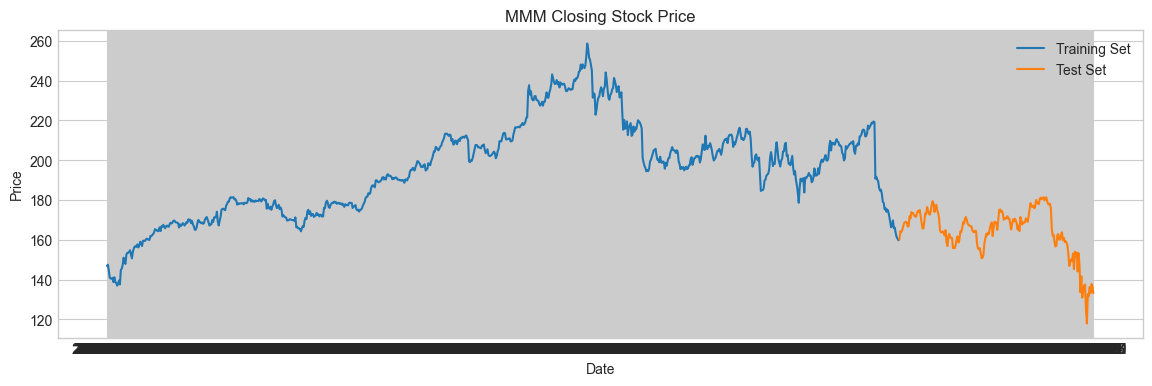

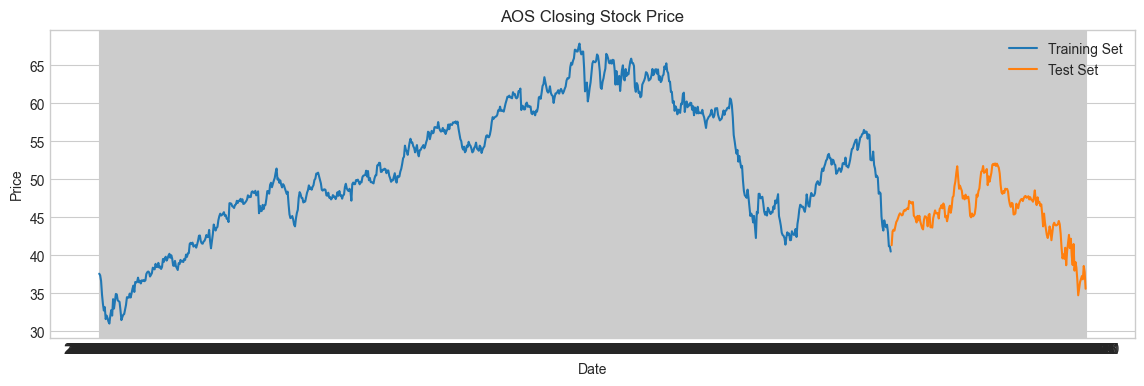

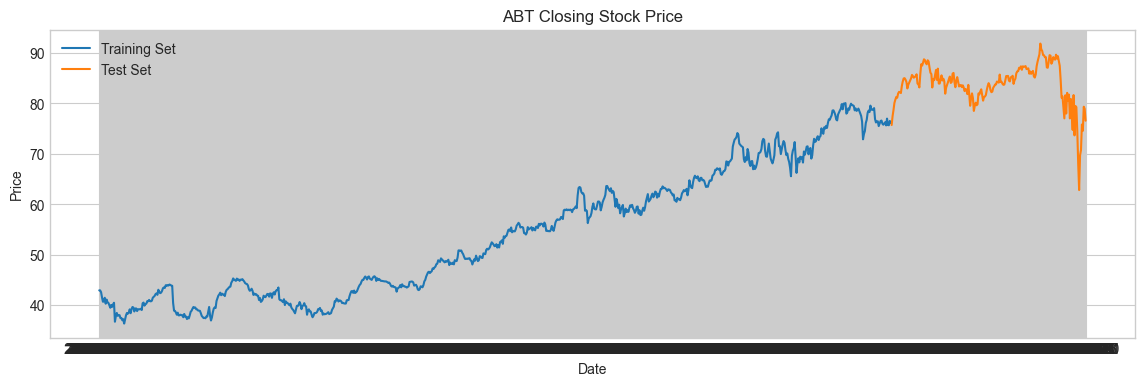

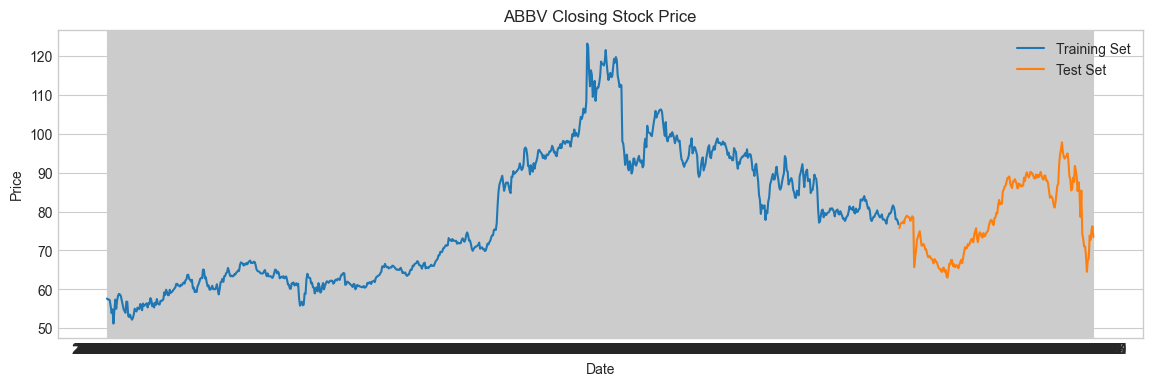

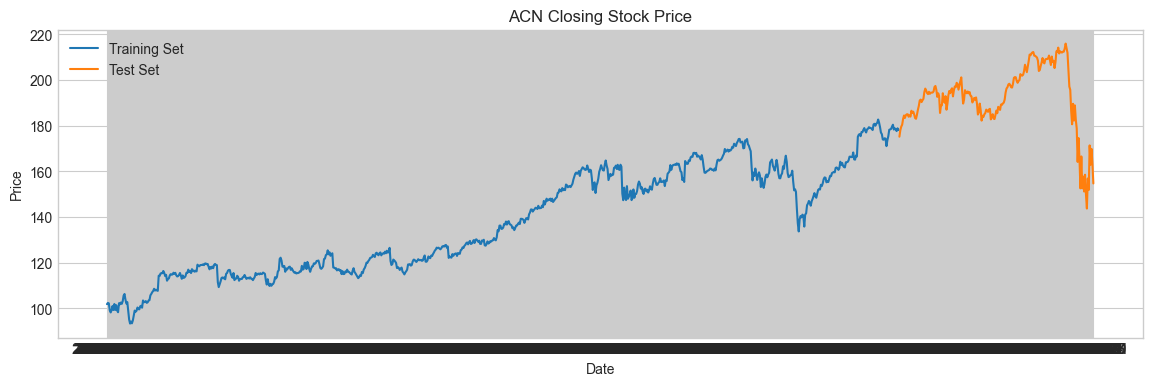

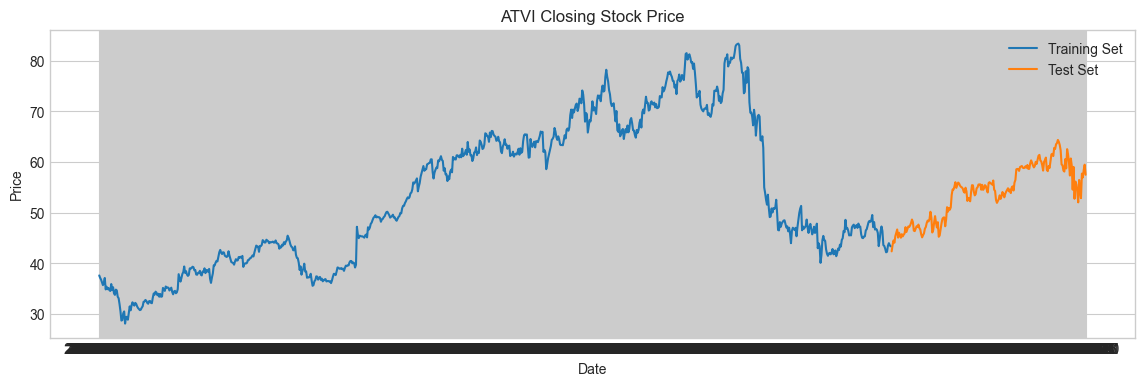

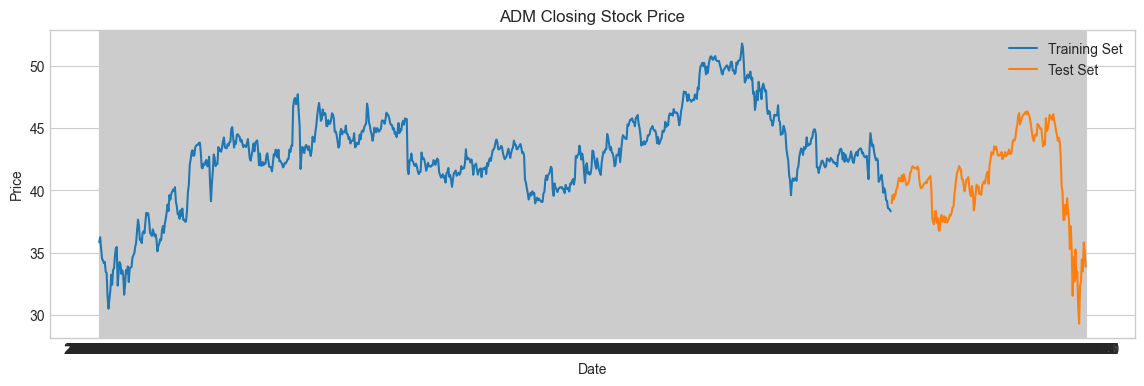

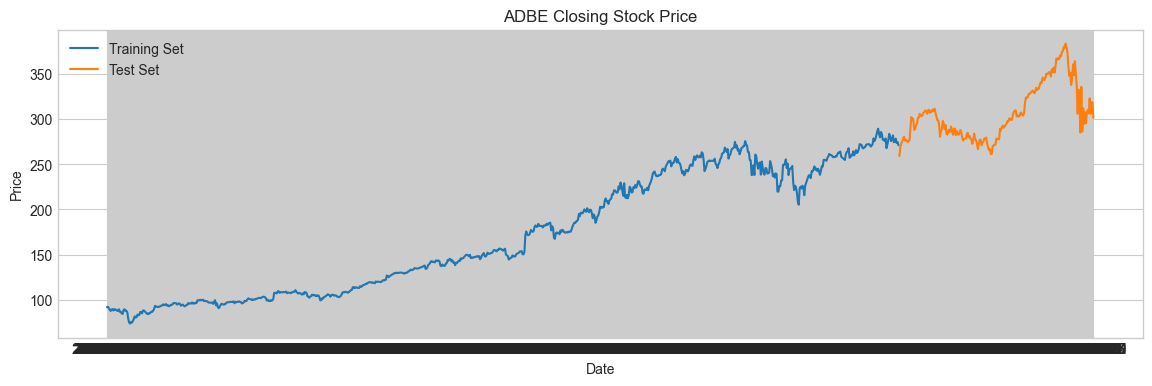

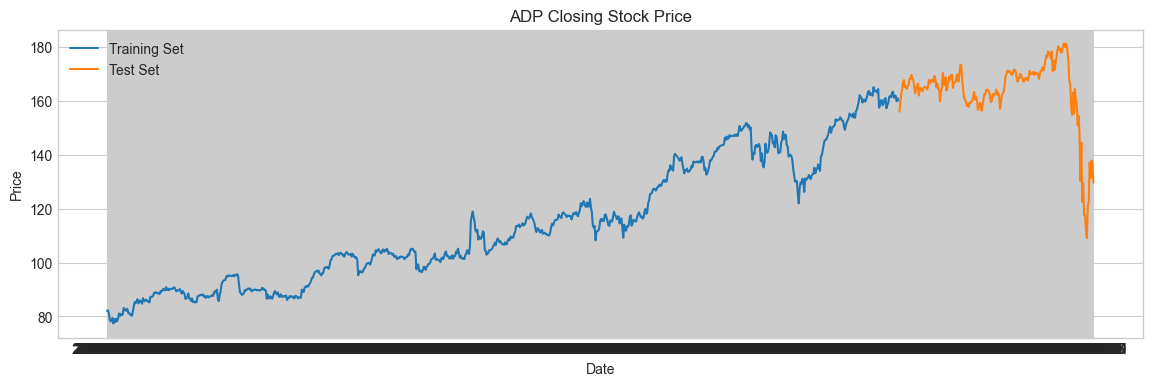

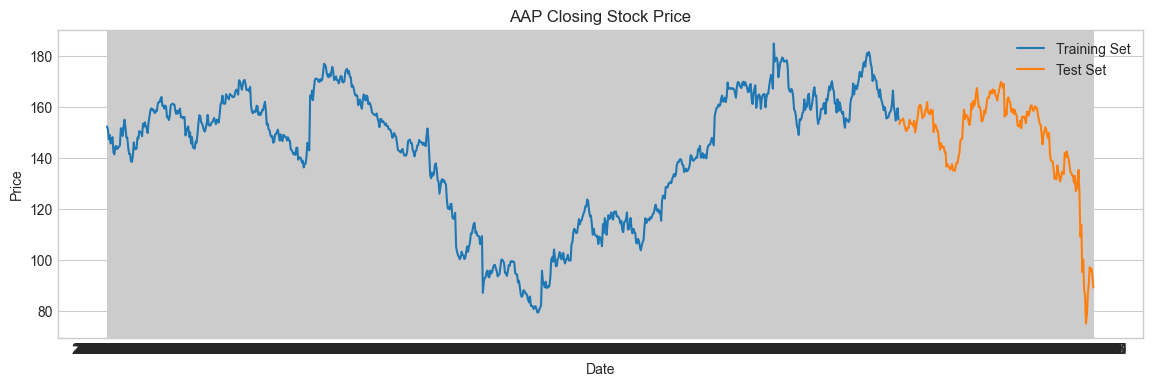

In [8]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

We rescale all stock price to zero for the lowest and 1 for the highest.
Each of the companies have their own scale. We make another two dictionaries which contain the scaled price for each company.
One contains train set and the other the test set.

We also create another dictionary for collecting the scaler. This will be useful when we want to inverse transform our prediction.

In [9]:



# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

We print the shape of our transformed set. A few of the companies have more than others. We will make the input be uniform for each stock ticker in terms of shape.

In [10]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

MMM (858, 1)
AOS (858, 1)
ABT (858, 1)
ABBV (858, 1)
ACN (858, 1)
ATVI (858, 1)
ADM (858, 1)
ADBE (858, 1)
ADP (858, 1)
AAP (858, 1)


MMM (211, 1)
AOS (211, 1)
ABT (211, 1)
ABBV (211, 1)
ACN (211, 1)
ATVI (211, 1)
ADM (211, 1)
ADBE (211, 1)
ADP (211, 1)
AAP (211, 1)


60 features should be enough for training. We prepare the shape for the NN.

In [11]:
trainset = {}
testset = {}
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,858):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 147):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

Check shape one last time before training

In [12]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
MMM,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
AOS,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
ABT,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
ABBV,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
ACN,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
ATVI,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
ADM,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
ADBE,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
ADP,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"
AAP,"(798, 60, 1)","(798,)","(87, 60, 1)","(87,)"


The LSTM model

In [13]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=15, batch_size=200)

Fitting to MMM
Epoch 1/15
4/4 [==============================] - 11s 320ms/step - loss: 0.1125
Epoch 2/15
4/4 [==============================] - 1s 365ms/step - loss: 0.0529
Epoch 3/15
4/4 [==============================] - 2s 371ms/step - loss: 0.0230
Epoch 4/15
4/4 [==============================] - 2s 381ms/step - loss: 0.0201
Epoch 5/15
4/4 [==============================] - 1s 371ms/step - loss: 0.0185
Epoch 6/15
4/4 [==============================] - 1s 366ms/step - loss: 0.0333
Epoch 7/15
4/4 [==============================] - 2s 382ms/step - loss: 0.0219
Epoch 8/15
4/4 [==============================] - 1s 334ms/step - loss: 0.0203
Epoch 9/15
4/4 [==============================] - 1s 335ms/step - loss: 0.0253
Epoch 10/15
4/4 [==============================] - 1s 356ms/step - loss: 0.0181
Epoch 11/15
4/4 [==============================] - 1s 320ms/step - loss: 0.0243
Epoch 12/15
4/4 [==============================] - 1s 344ms/step - loss: 0.0172
Epoch 13/15
4/4 [================

Visualizing predictions:

In [14]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    #plt.figure(figsize=(14,6))
    #plt.title("{} with MSE {:10.4f}".format(i,MSE))
    #plt.plot(y_true)
    #plt.plot(y_pred)

3/3 [==============================] - 0s 26ms/step


The prediction can be improved by introducing shifting/lagging. Essentially we slide our prediction for a period of time. This is a common practice in the signal processing subfield.


In [15]:
time_index = df_new["MMM"]["Test"][60:].index
def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    #print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    #print("MSE with Lag 5", mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5])))

    #plt.figure(figsize=(14,4))
    #plt.title("Prediction without Lag")
    #plt.xlabel("Date")
    #plt.ylabel("Price (USD)")
    #plt.plot(df_true)
    #plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5]))
    return df_pred_lag
    #plt.figure(figsize=(14,4))
    #plt.title("Prediction with Lag")
    #plt.xlabel("Date")
    #plt.ylabel("Price (USD)")
    #plt.plot(df_true)
    #plt.plot(df_pred_lag)

In [16]:

lagging(pred_result["MMM"], -5, time_index)

ValueError: Length of values (87) does not match length of index (151)

In [17]:
pred_result

{'MMM': {'True': array([[155.75      ],
         [157.55000305],
         [160.36000061],
         [161.72000122],
         [158.63999939],
         [160.07000732],
         [164.22999573],
         [163.94000244],
         [165.94000244],
         [168.86000061],
         [168.08000183],
         [170.58000183],
         [171.44000244],
         [169.66999817],
         [168.07000732],
         [167.44000244],
         [167.07000732],
         [166.75999451],
         [166.75999451],
         [164.74000549],
         [164.        ],
         [163.83000183],
         [164.52999878],
         [164.3999939 ],
         [158.38000488],
         [155.6499939 ],
         [155.22999573],
         [155.82000732],
         [153.52000427],
         [150.74000549],
         [150.99000549],
         [152.30999756],
         [158.1000061 ],
         [160.50999451],
         [162.97999573],
         [162.17999268],
         [163.53999329],
         [163.1000061 ],
         [165.94000244],
         [

In [18]:
# extract the predicted values and true values from the dictionary pred_result and store them in a dataframe
df_pred = pd.DataFrame()
df_true = pd.DataFrame()
for i in stockList:
    df_pred[i] = pred_result[i]["Pred"].reshape(-1)
    df_true[i] = pred_result[i]["True"].reshape(-1)
df = pd.concat([df_pred, df_true], axis=1)
# make header for predicted and true values
df.columns = [i+"_pred" for i in stockList] + [i+"_true" for i in stockList]
df.head()


,MMM_pred,AOS_pred,ABT_pred,ABBV_pred,ACN_pred,ATVI_pred,ADM_pred,ADBE_pred,ADP_pred,AAP_pred,MMM_true,AOS_true,ABT_true,ABBV_true,ACN_true,ATVI_true,ADM_true,ADBE_true,ADP_true,AAP_true
0,161.009460,46.059566,84.610924,65.290298,192.465744,47.850723,37.790951,289.549164,166.332626,138.701370,155.750000,44.480000,83.650002,65.669998,197.160004,51.090000,37.419998,289.450012,166.850006,134.889999
1,160.561035,46.114708,84.473747,65.490616,192.939545,47.962070,37.771599,289.266541,166.509598,138.071503,157.550003,45.090000,84.220001,66.070000,196.839996,50.209999,37.570000,282.130005,167.220001,136.759995
2,160.114502,46.120258,84.330437,65.693329,193.445007,48.134964,37.769676,289.046722,166.633972,137.542587,160.360001,46.130001,84.820000,66.220001,198.740005,50.959999,37.730000,286.630005,169.440002,138.070007
3,159.706406,46.091331,84.201515,65.882172,193.980591,48.369495,37.780216,288.863983,166.729675,137.139328,161.720001,46.520000,85.320000,65.739998,198.169998,50.599998,38.049999,284.510010,169.839996,137.949997
4,159.388535,46.050056,84.108017,66.043388,194.536652,48.654877,37.802555,288.690491,166.826035,136.875443,158.639999,45.599998,84.059998,65.400002,195.750000,51.060001,37.990002,282.450012,167.210007,140.360001


In [19]:
# Calculate the daily returns for each stock using the predicted and true values:
df_returns_pred = df_pred.pct_change().dropna()
df_returns_true = df_true.pct_change().dropna()
# print(df_returns_pred, df_returns_true)
# # Calculate the expected returns and covariance matrix of the returns:
# mean_returns_pred = df_returns_pred.mean()
# mean_returns_true = df_returns_true.mean()
# cov_matrix_pred = df_returns_pred.cov()
# cov_matrix_true = df_returns_true.cov()

# Define a function to calculate the portfolio returns and risk for a given set of weights:
# def portfolio_performance(weights, mean_returns, cov_matrix):
#     returns = np.sum(mean_returns * weights) * 252
#     risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
#     return returns, risk
    

In [26]:
import numpy as np
from scipy.optimize import minimize

# Calculate expected returns and covariance matrix
mu = df_pred.mean().values
Sigma = df_pred.cov().values

# Define variables
n_assets = len(mu)
w = np.ones(n_assets) / n_assets

# Define objective function
def objective(w):
    return np.dot(np.dot(w, Sigma), w)

# Define constraints
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: x}]

# Solve optimization problem for a range of target returns
target_returns = np.linspace(mu.min(), mu.max(), num=100)
risk_data = []
ret_data = []
for tr in target_returns:
    # Define new constraints
    cons_new = cons + [{'type': 'ineq', 'fun': lambda x: tr - np.dot(mu, x)}]

    # Solve optimization problem
    res = minimize(objective, w, method='SLSQP', constraints=cons_new)
    if res.success:
        # Save results
        ret_data.append(tr)
        risk_data.append(np.sqrt(objective(res.x)))
    else:
        print('Optimization failed for target return:', tr)

# Calculate efficient frontier
ef = pd.DataFrame({'ret': ret_data, 'risk': risk_data})
ef.set_index('ret', inplace=True)

# Select optimal portfolio for max return
# max_ret = ef['risk'].idxmin()
max_ret = 10
res = minimize(objective, w, method='SLSQP', constraints=cons + [{'type': 'eq', 'fun': lambda x: objective(x) - max_ret}])

if res.success:
    weights = res.x
    # Select top 5 stocks
    top5_idx = np.argsort(weights)[-5:]
    top5_stocks = df_pred.columns[top5_idx]
else:
    print('Optimization failed for max return:', max_ret)



In [45]:
# DET HER ER EN MEGET STOR PROTOTYPE... IKKE SE DEN SOM OFFICIEL ENDNU!!!
# for the top 5 stocks in the portfolio, we want to extract them and make a new dataframe with the predicted values
# and true values for the top 5 stocks
df_top5 = pd.DataFrame()
for i in top5_stocks:
    df_top5[i+"_pred"] = df_pred[i]
    df_top5[i+"_true"] = df_true[i]
df_top5.head()

# change the prices to returns in percent
df_top5_returns = df_top5.pct_change().dropna() * 100
df_top5_returns.head()

# calculate the mean returns and covariance matrix
mean_returns = df_top5_returns.mean()
cov_matrix = df_top5_returns.cov()
print(mean_returns)
print(cov_matrix)

# set up the optimal weights for the portfolio
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# extract the true values from the dataframe
df_top5_true = df_top5.iloc[:, 5:]
df_top5_true.head()

# calculate the portfolio returns
mean_returns = df_top5_true.mean()

portfolio_returns = mean_returns.dot(weights)
portfolio_returns







ADP_pred     0.009951
ADP_true     0.024423
ADM_pred     0.202596
ADM_true     0.249839
ATVI_pred    0.233340
ATVI_true    0.176381
ABT_pred     0.022036
ABT_true     0.048658
AOS_pred     0.018568
AOS_true     0.089744
dtype: float64
           ADP_pred  ADP_true  ADM_pred  ADM_true  ATVI_pred  ATVI_true  \
ADP_pred   0.058262 -0.038769 -0.037642  0.029684  -0.036697   0.038705   
ADP_true  -0.038769  1.104378  0.010087  0.005719  -0.076610   0.374516   
ADM_pred  -0.037642  0.010087  0.098256 -0.023343   0.070900  -0.074933   
ADM_true   0.029684  0.005719 -0.023343  1.310110   0.094346   0.146804   
ATVI_pred -0.036697 -0.076610  0.070900  0.094346   0.197475   0.009182   
ATVI_true  0.038705  0.374516 -0.074933  0.146804   0.009182   2.281649   
ABT_pred   0.012784 -0.018453  0.027248  0.023289   0.012907  -0.012287   
ABT_true   0.006015  0.606111 -0.011342  0.282872  -0.002599   0.451042   
AOS_pred  -0.014856 -0.027625  0.088405  0.010110   0.088788  -0.097589   
AOS_true   0.01

63.724779580653404

In [301]:
top5_stocks
# Calculate expected returns in % for the top 5 stocks
mu[top5_idx]
# show true returns for the top 5 stocks
df_true[top5_stocks].mean().values
print("The top 5 stocks are: ", top5_stocks)
print("The expected returns for the top 5 stocks are: ", mu[top5_idx])
print("The true returns for the top 5 stocks are: ", df_true[top5_stocks].mean().values)


The top 5 stocks are:  Index(['ADP', 'ADM', 'ATVI', 'ABT', 'AOS'], dtype='object')
The expected returns for the top 5 stocks are:  [165.21834   41.27783   54.241913  83.851585  48.44468 ]
The true returns for the top 5 stocks are:  [165.02402312  41.86540244  54.89862056  83.75954034  48.33229889]


In [142]:
# determine which stocks have the best prediction and which have the best performances in terms of stock price change

# weigh the prediction and the performance to find the best 5 stocks to invest in
# the weight of the prediction is 0.7 and the weight of the performance is 0.3
# the best stock is the one with the highest score
best5_weighted = sorted(pred_result.items(), key=lambda x: 0.8*mean_squared_error(x[1]["True"], x[1]["Pred"]) + 0.2*(x[1]["True"][-1] - x[1]["True"][0]))[:5]

# only pick the ticker name of the best 5 stocks
best5_weighted = [i[0] for i in best5_weighted]
best5_weighted

['AFL', 'MO', 'AAL', 'AIG', 'AMCR']

In [143]:
# calculating the actual stock price change in percent for the best 5 stocks
best5_weighted_change = {}
for i in best5_weighted:
    best5_weighted_change[i] = (pred_result[i]["True"][-1] - pred_result[i]["True"][0])/pred_result[i]["True"][0]*100

# print the best 5 stocks to invest in
print("The best 5 stocks to invest in are:", best5_weighted)


best5_weighted_change

The best 5 stocks to invest in are: ['AFL', 'MO', 'AAL', 'AIG', 'AMCR']


{'AFL': array([-20.70688796]),
 'MO': array([-22.58869079]),
 'AAL': array([-37.70438429]),
 'AIG': array([-20.57272345]),
 'AMCR': array([-16.63685653])}